In [1]:
# Dirichlet‑Process clustering of NDVI time series
# Piece‑wise (Loredo‑style) temporal model
# PyMC implementation with truncated DP and sequential updating

import numpy as np
import pymc as pm
import pytensor.tensor as pt
from matplotlib import pyplot as plt

In [2]:
# ============================================================
# USER PARAMETERS
# ============================================================
MAX_CLUSTERS = 10          # truncation level of DP
N_SEGMENTS   = 23          # piece‑wise bins for temporal model (e.g. 23 for 16‑day NDVI)
ALPHA_DP     = 1.0         # DP concentration
SIGMA_MODIS  = 0.02        # NDVI noise (~MODIS typical)

In [3]:
# ============================================================
# UTILITIES
# ============================================================

def doy_to_bin(doy, n_segments=N_SEGMENTS):
    """Map day-of-year to piecewise bin"""
    return np.floor((doy % 365) / 365 * n_segments).astype(int)

In [4]:
def build_model_multi(series_bins, series_values):
    """
    series_bins : list of arrays of bins per series
    series_values: list of NDVI arrays
    """

    n_series = len(series_values)

    with pm.Model() as model:
        # ---------- Stick‑breaking DP ----------
        beta = pm.Beta("beta", 1, ALPHA_DP, shape=MAX_CLUSTERS)
        pi = pm.Deterministic("pi", pm.math.concatenate([beta[0:1], beta[1:] * pt.extra_ops.cumprod(1 - beta[:-1])]))
        pi = pi / pm.math.sum(pi)

        # ---------- Piecewise NDVI per cluster ----------
        # a = pm.Uniform("a", lower=-0.1, upper=1.0, shape=(MAX_CLUSTERS, N_SEGMENTS))
        a = pm.Uniform("a", lower=0, upper=1.0, shape=(MAX_CLUSTERS, N_SEGMENTS))
        sigma = pm.HalfNormal("sigma", SIGMA_MODIS)

        # ---------- Cluster assignment per SERIES ----------
        z = pm.Categorical("z", p=pi, shape=n_series)

        # ---------- Likelihood per series ----------
        for i in range(n_series):
            mu_i = a[z[i], series_bins[i]]
            pm.Normal(f"y_{i}", mu=mu_i, sigma=sigma,
            observed=series_values[i])

    return model


In [5]:
def synthetic_series(n_series):
    """Generate synthetic NDVI series with 3 clusters: bosque, cultivo anual, doble cultivo"""
    # n_series = 30
    n_quincenas = 23
    quincenas = np.arange(n_quincenas)
    # days = np.arange(n_days)

    series = []
    true_clusters = []

    for i in range(n_series):
        c = np.random.choice([0,1,2])
        true_clusters.append(c)

        if c == 0:   # bosque
            ndvi = 0.3 + 0.1*np.sin(2*np.pi*quincenas/23)

        elif c == 1: # cultivo anual
            ndvi = 0.2 + 0.4*((quincenas>6)&(quincenas<25))

        else:        # doble cultivo
            ndvi = 0.2 + 0.3*((quincenas>4)&(quincenas<7)) \
                        + 0.3*((quincenas>10)&(quincenas<13))

        ndvi += np.random.normal(0, SIGMA_MODIS, size=n_quincenas)
        series.append(ndvi)
    return quincenas, np.array(series), np.array(true_clusters)


In [6]:
quincenas, series, true_clusters = synthetic_series(n_series=30)

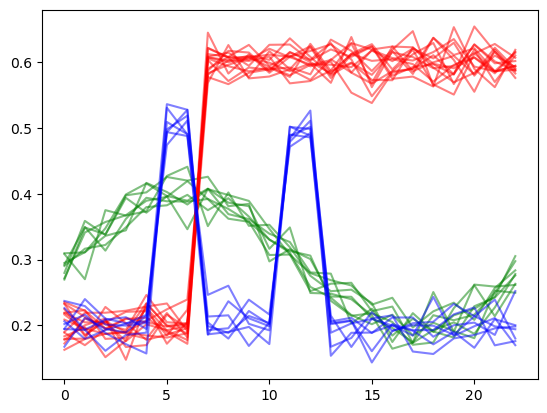

In [7]:
plt.plot(series[true_clusters == 0, :].T, color='green', alpha=0.5)
plt.plot(series[true_clusters == 1, :].T, color='red', alpha=0.5)
plt.plot(series[true_clusters == 2, :].T, color='blue', alpha=0.5)
# plt.plot(true_clusters)

In [ ]:

np.random.seed(0)

quincenas, series, true_clusters = synthetic_series(25)
# series_bins = [doy_to_bin(quincenas) for _ in series]
series_bins = [quincenas for _ in series]
model = build_model_multi(series_bins, series)

with model:
    trace = pm.sample(draws=5000, tune=1000, chains=4)
    z_post = trace.posterior["z"].mean(dim=("chain","draw")).values
    z_est = np.round(z_post).astype(int)

print("True clusters:")
print(true_clusters)
print("Estimated clusters:")
print(z_est)
print("Estimated N:", len(np.unique(z_est)))


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [beta, a, sigma]
>CategoricalGibbsMetropolis: [z]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 51 seconds.
There were 257 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


True clusters:
[0 1 1 2 0 2 1 1 2 0 1 2 2 2 0 1 0 1 2 2 1 1 0 0 2]
Estimated clusters:
[0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0]
Estimated N: 2


Evaluacion clusters

In [9]:
# import numpy as np
# import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

def aligned_confusion(true_labels, est_labels):
    true_labels = np.array(true_labels)
    est_labels  = np.array(est_labels)

    cm = confusion_matrix(true_labels, est_labels)

    # Hungarian algorithm → maximizar diagonal
    row_ind, col_ind = linear_sum_assignment(-cm)

    aligned_cm = cm[:, col_ind]
    mapping = {col_ind[i]: row_ind[i] for i in range(len(row_ind))}

    aligned_est = np.array([mapping[e] for e in est_labels])

    return aligned_cm, aligned_est, mapping


In [10]:
def plot_confusion(cm, title="Confusion Matrix"):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.xlabel("Estimated cluster")
    plt.ylabel("True cluster")
    plt.colorbar()

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j],
                     ha="center", va="center",
                     fontsize=12)

    plt.tight_layout()
    plt.show()


Cluster mapping: {2: 0, 1: 1, 0: 2}


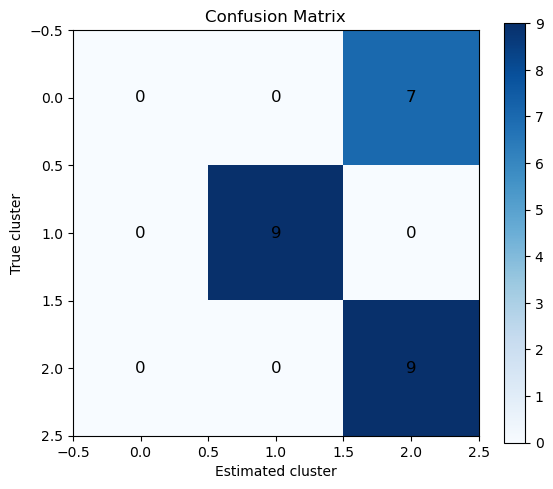

In [11]:
cm, aligned_est, mapping = aligned_confusion(true_clusters, z_est)

print("Cluster mapping:", mapping)
plot_confusion(cm)


Evaluacion series de tiempo

In [ ]:
def plot_cluster_ndvi_posterior(trace, quincenas, z_est, n_segments=12, ci=0.9):
    """
    trace   : trace de PyMC
    quincenas    : array quincenas
    z_est   : cluster asignado por serie
    """

    a_post = trace.posterior["a"].stack(sample=("chain","draw")).values
    # shape = (Kmax, N_segments, n_samples)

    clusters = np.unique(z_est)
    # bins = np.floor((days % 365) / 365 * n_segments).astype(int)
    bins = quincenas

    plt.figure(figsize=(10,6))

    for k in clusters:

        samples = a_post[k, bins, :]  # (365, n_samples)

        mean = samples.mean(axis=1)
        low  = np.percentile(samples, (1-ci)/2*100, axis=1)
        high = np.percentile(samples, (1+(ci))/2*100, axis=1)

        n_series = np.sum(z_est == k)

        plt.plot(quincenas, mean, label=f"Cluster {k} (n={n_series})")
        plt.fill_between(quincenas, low, high, alpha=0.25)

    plt.xlabel("Quincena")
    plt.ylabel("NDVI")
    plt.title("NDVI promedio por cluster (posterior PyMC)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
plot_cluster_ndvi_posterior(trace, quincenas, z_est)